<div style="text-align: center; background-color: #559cff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  FINAL PROJECT – Introduction to Data Science
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    Exploratory data analysis
</div>

## Import

In [1]:

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats

# import geopandas
%matplotlib inline

import seaborn as sns

## Exploring data

### Pre-processing

Read final data from file

In [2]:
fin_df = pd.read_csv("./data/final_data.csv")
fin_df.shape

(3491, 37)

Remove all rows that have outliers in columns representing percentage information

In [3]:
pct_cols = fin_df.columns.str.contains('func_exp_pct')
pct_cols = fin_df.columns[pct_cols]

df = fin_df[(np.abs(stats.zscore(fin_df[pct_cols])) < 3).all(axis=1)]

We observe that the column 'hospital_id', 'ein', 'medicare_provider_number', 'fiscal_yr' has numeric type. However, its magnitude does not have a significance. And, they actually represents a period instead of a number. Thus, they can be convert to categorical type.

In [12]:
str_cols = ['hospital_id', 'ein', 'medicare_provider_number', 'fiscal_yr']
df[str_cols] = df[str_cols].astype(str)

### Making questions

**Question 1:** What is the correlation between numeric features in the dataset?

**Answering this question will** help us to have a general view about this dataset, identify and analyse the relationships between features and then determine which features within the dataset significantly contribute to our solution goal.

**How we answer this question**: create a correlation matrix, then visualize the matrix using heat map.

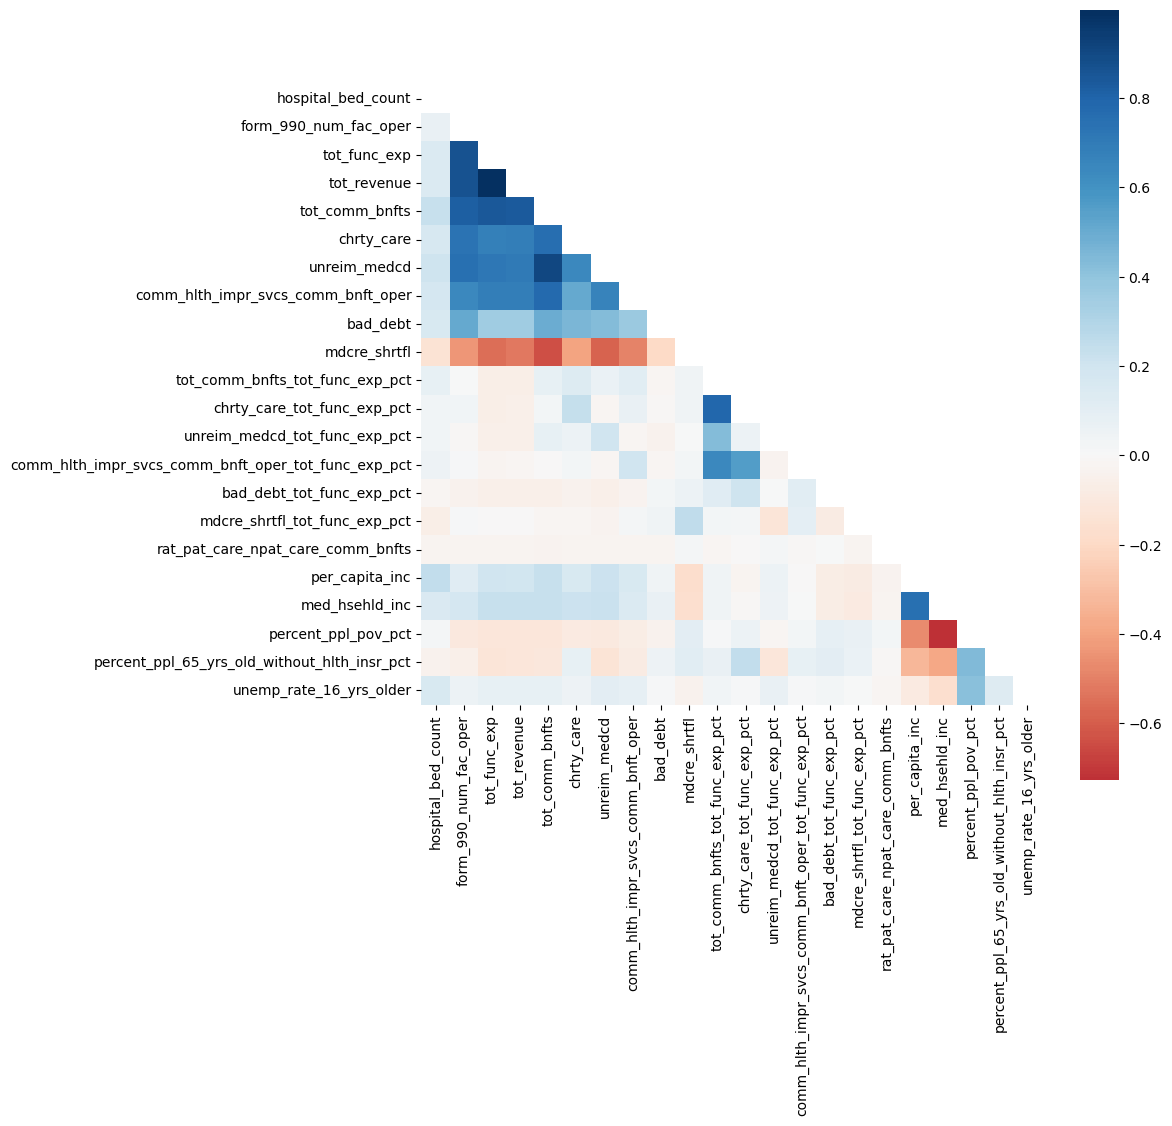

In [46]:
df_copy = df.copy()
corr = df_copy.corr()
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(corr, cmap='RdBu', center=0,ax=ax, square=True, mask=matrix)
plt.show()

**Answer:** There are 3 regions that their features has significant influence to each other. They are (listed from High to Low, from Left to Right): 
- Group 1: a triangle creating a group representing financial records of each hospital. Most of them have positive correlation except the `mdcre_shrtfl`.
- Group 2: inclucdes correlation between `tot_comm_bnfts_tot_func_exp_pct`, `chrty_care_tot_func_exp_pct`, `unreim_medcd_tot_func_exp_pct`, `comm_hlth_impr_svcs_comm_bnft_oper_tot_func_exp_pct` which represent various percentages calculated in relation to the total functional expenses.
- Group 3: a triangle representing socio-economic indicators that are often used to assess and analyze the economic well-being and health status of a population within a specific area or region around each hospital.
- Other regions has small correlation ratios, therefore, their relation are not significant. 

Let research more about the group 1 which haves the strongest correlation in the whole matrix. We'll create a smaller correlation matrix of only group 1's features to discover more.

<Axes: >

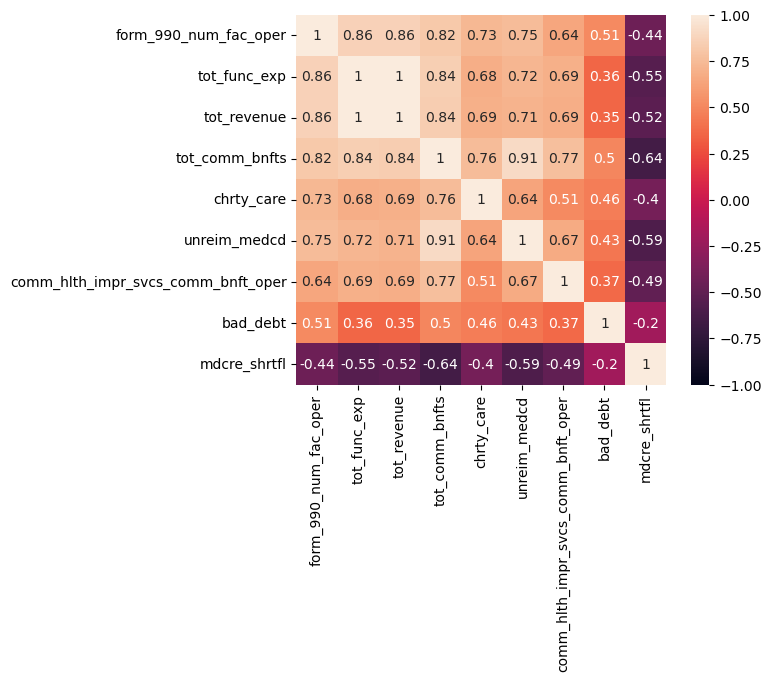

In [48]:
df_corr = df[['form_990_num_fac_oper',
       'tot_func_exp', 'tot_revenue', 'tot_comm_bnfts', 'chrty_care',
       'unreim_medcd', 'comm_hlth_impr_svcs_comm_bnft_oper', 'bad_debt',
       'mdcre_shrtfl']].corr()

sns.heatmap(corr_df, square=True, annot=True, fmt='.2g',vmax=1,vmin=-1)

**Answer:** As we can see, `tot_comm_bnfts` is the lightest row, which means these features has the strongest correlation with others (most of them is higher than 75%, except for `bad_debt`: 0.5 and `mdcre_shrtfl`: -0.64). Especially, `tot_comm_bnfts` and `unreim_medcd` has the positive correlation point up to 91%. On the other hand, `tot_revenue` and `tot_func_exp` has the absolute point of correlation with 100%, which means the higher a hospital's revenue, the higher expenses they use for functional improvement. 

Based on this correlation matrix, we will find out more about the relationship between this group of features: `tot_func_exp`, `tot_revenue`, `tot_comm_bnfts`, `chrty_care`,
`unreim_medcd`, `comm_hlth_impr_svcs_comm_bnft_oper`, `bad_debt`, `mdcre_shrtfl` and the others.

**Question 2:** What is the financial situation of hospitals and the quality of life in each US state?

**Answering this question will** indicate whether states with fine financial situation lead to high quality of life.

**How we answer this question**: find top 5 hightest revenue and lowest revenue each state have from hospitals. Then ploting their financial columns and percentage of people in poverty, people without health insurance, and unemployments.

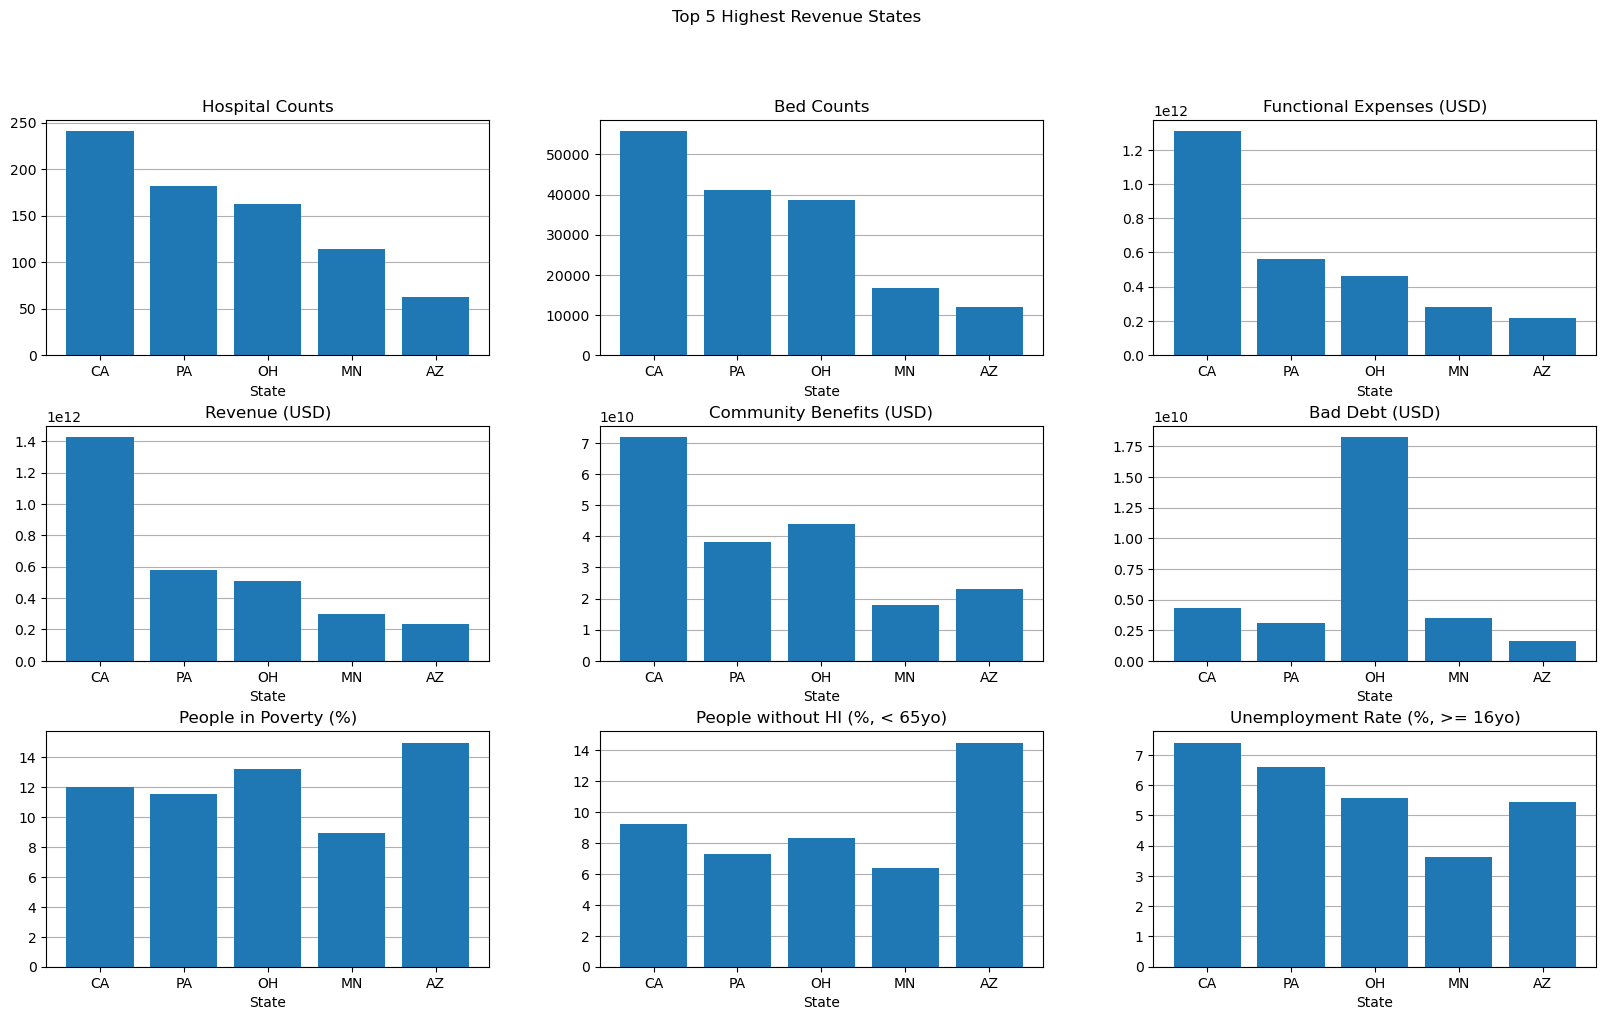

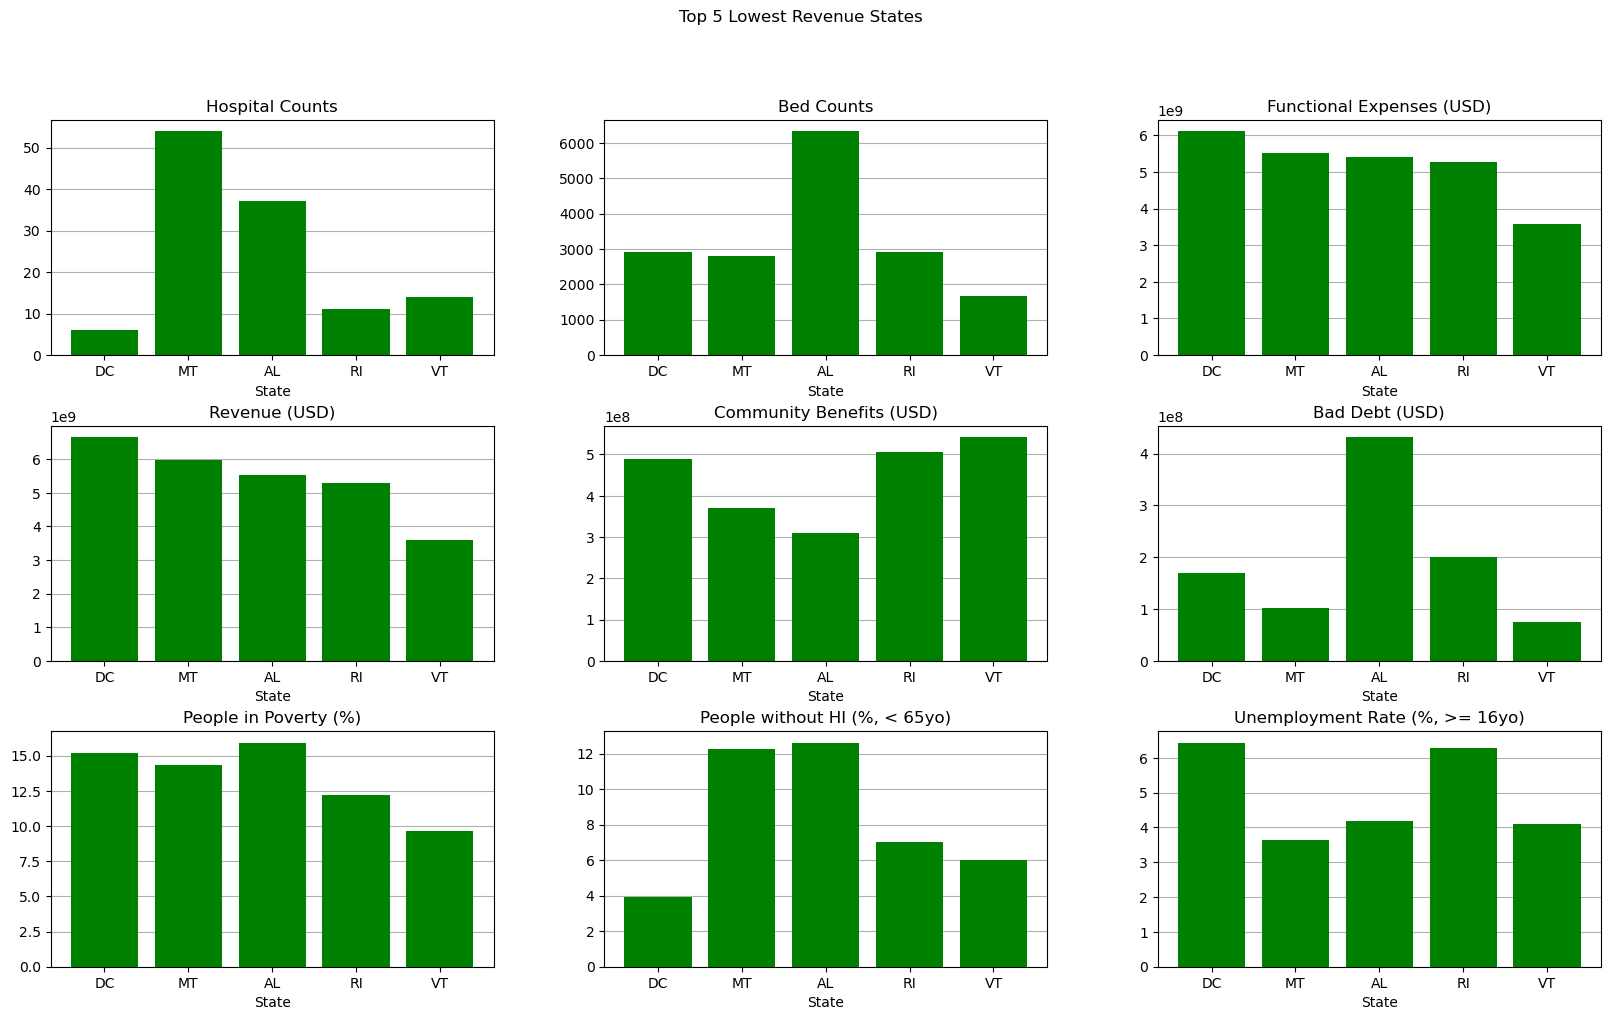

In [7]:
fin_df = df[['state','hospital_bed_count', 'tot_func_exp', 'tot_revenue', 'tot_comm_bnfts', 'bad_debt']]
comm_df = df[['state', 'percent_ppl_pov_pct', 'percent_ppl_65_yrs_old_without_hlth_insr_pct', 'unemp_rate_16_yrs_older']]

fin_df = fin_df.groupby('state').sum()
comm_df = comm_df.groupby('state').mean()

state_df = pd.DataFrame()
state_df['num_of_hostpital'] = df.groupby('state')['hospital_id'].count()
state_df = pd.concat([state_df, fin_df, comm_df], axis=1)
state_df['state'] = state_df.index
state_df.sort_values('tot_func_exp', inplace=True, ascending=False)
state_df.reset_index(drop=True, inplace=True)

state_df.columns = ['Hospital Counts' ,'Bed Counts', 'Functional Expenses (USD)', 'Revenue (USD)', 'Community Benefits (USD)', 'Bad Debt (USD)', 'People in Poverty (%)', 'People without HI (%, < 65yo)', 'Unemployment Rate (%, >= 16yo)', 'State']
state_cols = state_df.columns[:-1]



high_re_states = state_df.head()
low_re_states = state_df.tail()

fig, axes = plt.subplots(3, 3, figsize=(20, 11))
fig.subplots_adjust(hspace = .3, wspace=.25)
plt.suptitle('Top 5 Highest Revenue States')

for col, ax in zip(state_cols, axes.ravel()):
  df_copy = high_re_states
  ax.bar(df_copy['State'], df_copy[col])
  
  ax.set_xlabel('State')
#   ax.set_ylabel('USD')
  ax.set_title(f'{col}')
  ax.grid(axis='y')
  ax.set_axisbelow(True)

fig, axes = plt.subplots(3, 3, figsize=(20, 11))
fig.subplots_adjust(hspace = .3, wspace=.25)
plt.suptitle('Top 5 Lowest Revenue States')

for col, ax in zip(state_cols, axes.ravel()):
  df_copy = low_re_states
  ax.bar(df_copy['State'], df_copy[col], color='green')
  
  ax.set_xlabel('State')
#   ax.set_ylabel('USD')
  ax.set_title(f'{col}')
  ax.grid(axis='y')
  ax.set_axisbelow(True)
 

**Answer:** In states with high hospital revenue, their order in the other features is based on revenue order, meaning that high revenue leads to number of hospitals, number of beds, non-functional expenditures, and the community benefits also remain in the same order. However, in states with low hospital revenue, these orders are not similar, for example, the state with the highest revenue such as DC has a very low number of hospitals and hospital beds. There is not much difference in the quality of life of people in high and low revenue states, with poverty rates ranging from less than 10% to more than 15%. In contrast, the proportion of people with health insurance and the unemployment rate are higher in large states than in small states.

**Question 3:** How do hospitals in each state in USA allocate funds for community benefits?

**Answering this question will** indicate how hospital in USA contribute to community around their area.

**How we answer this question**: extract sum money each state uses for community benefit and the average charity care, and community improvement services percentages, then visualize them to see how diffence. We can not draw all hospital so we will only choose top 5 highest and lowest average functional expenses for visualization.

<Axes: title={'center': '5 Lowest Expenses'}, xlabel='State'>

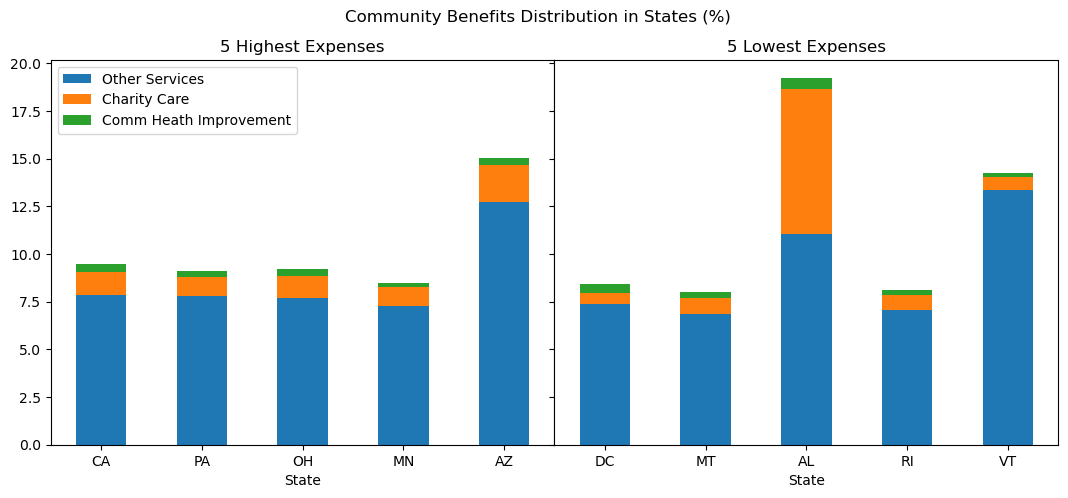

In [8]:
state_df = pd.DataFrame()
state_df['sum_func_exp'] = df.groupby('state')['tot_func_exp'].sum()
# state_df['avg_comm_bnfts'] = df.groupby('state')['tot_comm_bnfts_tot_func_exp_pct'].mean()
state_df['Charity Care'] = df.groupby('state')['chrty_care_tot_func_exp_pct'].mean()
state_df['Comm Heath Improvement'] = df.groupby('state')['comm_hlth_impr_svcs_comm_bnft_oper_tot_func_exp_pct'].mean()
state_df['Other Services'] = df.groupby('state')['tot_comm_bnfts_tot_func_exp_pct'].mean() - state_df['Charity Care'] - state_df['Comm Heath Improvement']
state_df.sort_values('sum_func_exp', inplace=True, ascending=False)

temp = state_df[['Other Services', 'Charity Care', 'Comm Heath Improvement']]

high_func_exp_states = temp.head().index
low_func_exp_states = temp.tail().index

high_exp_df = temp.loc[high_func_exp_states, :]
low_exp_df = temp.loc[low_func_exp_states, :]

fig, ax = plt.subplots(1, 2, figsize = (13, 5), sharey=True)
plt.subplots_adjust(wspace=0)
plt.suptitle('Community Benefits Distribution in States (%)')
high_exp_df.plot(kind='bar', ax=ax[0], xlabel='State', stacked=True, title='5 Highest Expenses', rot=0).legend(loc='upper left')
low_exp_df.plot(kind='bar', ax=ax[1], xlabel='State', stacked=True, title='5 Lowest Expenses', rot=0, legend=None)

**Answer :** In state of the top 10 highest-expense states, nearly 10% of their total functional expenses are allocated towards community benefits. Among these, charity care typically represents a higher percentage compared to community health improvement activities. Conversely, in the 10 lowest-expense states, despite lower total functional expenses, a significant focus remains on community benefits. Notably, Alabama (AL) dedicates nearly 20% of its total expenses to community benefits, surpassing the highest percentage observed among the top 10 highest-expense states (16%).

**Question 4:** The number of hospitals prioritizing patient-centric care (treatment and direct patient support) versus non-patient-oriented hospitals their activities aimed at the general community's health and well-being, in both urban and rural area.

**Answering this question will** reveal the types of hospitals prevalent in various regions across the USA.

**How we answer this question**: add a new column to label each hospital kind as 'patient' or 'non-patient' based on Ratio of Patient Care to Non-patient Care Community Benefits. Count number of each kind in each area of USA: urban or rural.

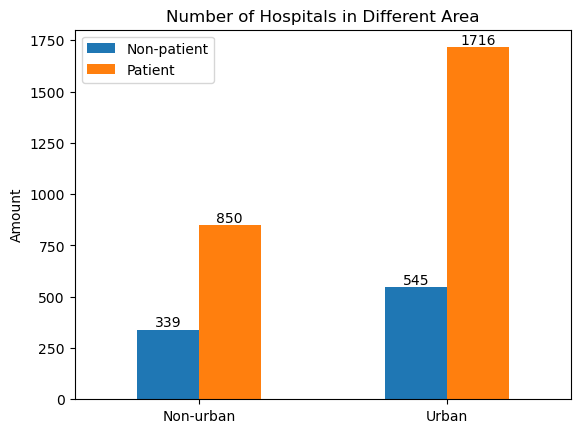

In [9]:
# pre-processing
temp = df[df['rat_pat_care_npat_care_comm_bnfts'] > 0]

# create array to store new columns: rat_pat_care_npat_care_comm_bnfts < 1 -> 'non-patient' else 'patient'
hos_type = np.full((temp.shape[0],), 'patient', dtype=object)
hos_type[temp['rat_pat_care_npat_care_comm_bnfts'] < 1] = 'non-patient'

# attach new columns to df
temp['type'] = hos_type

# count number of hospital in each type in urban and non-urban area
temp = temp.groupby(['urban_location_f','type'])['hospital_id'].count()
temp = temp.to_numpy().reshape(2, 2)

hos_type_df = pd.DataFrame(temp, index=['Non-urban', 'Urban'], columns=['Non-patient','Patient'])

ax = hos_type_df.plot(kind='bar', ylabel='Amount', rot=0, title='Number of Hospitals in Different Area')
for container in ax.containers:
    ax.bar_label(container)

**Answer:** Both urban and non-urban area have number of patient-oriented hospital more than community-oriented. However, in non-urban area, the community-oriented one take account of nearly 1/3 of the total number of hospital, while in urban area, this ratio is only 1/4.

**Question 5:** What impact do state laws requiring hospitals to report community benefits have on the allocation of resources towards community benefit programs?

**Answering this question will** indicate the influence or correlation between state laws mandating hospitals to report community benefits and the allocation of resources towards community benefit programs.

**How we answer this question**: plot the bar with grey bar represent not law state and red bar represent having law state. Then comparing the contribution of different state for community with or without report law.

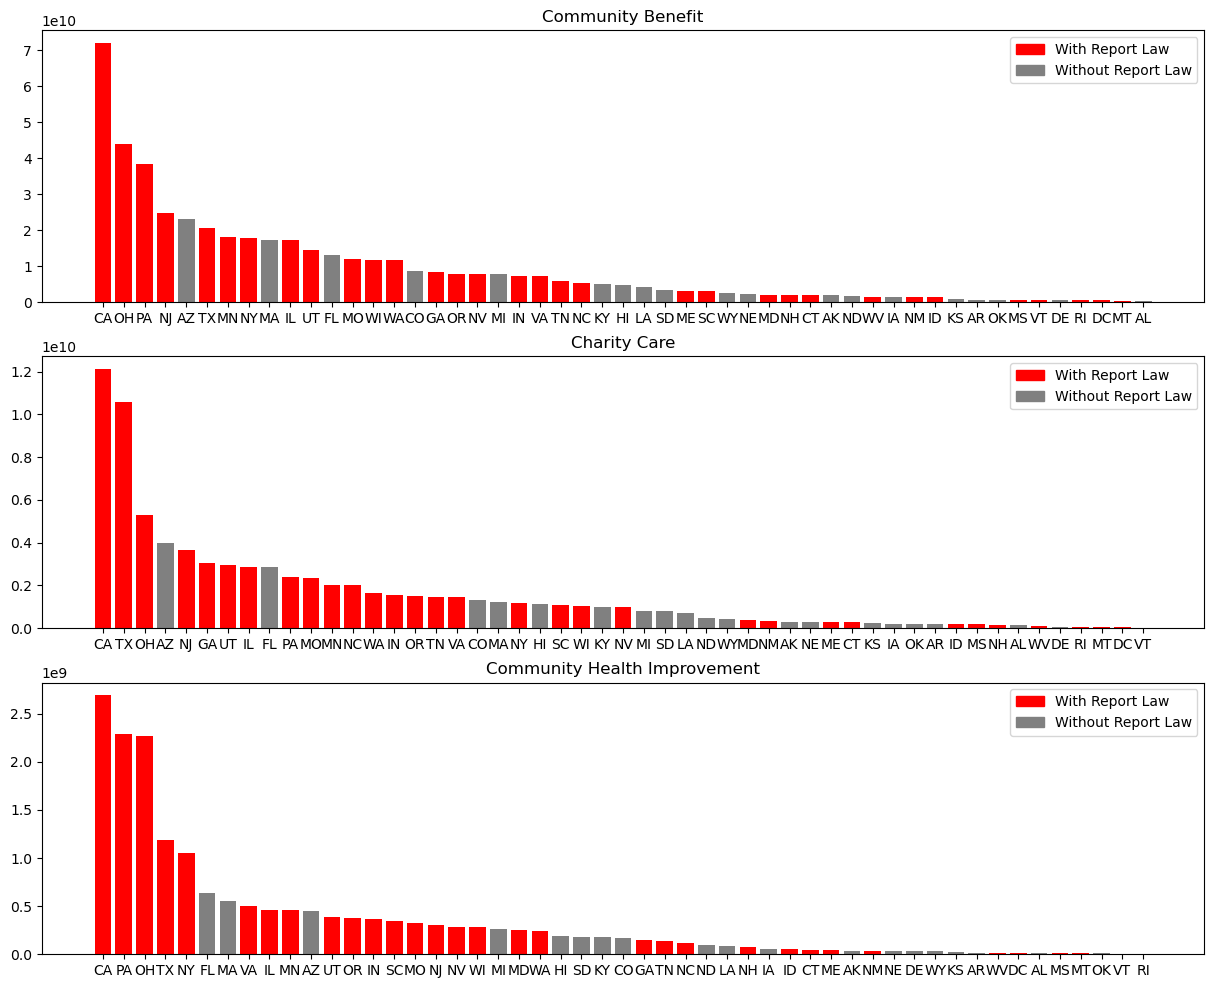

In [34]:
law_check = df[['state', 'st_law_req_hosp_rpt_comm_bnfts_f']].drop_duplicates()

law_df = pd.DataFrame()
law_df[['Community Benefit', 'Charity Care','Community Health Improvement']] = df[['state', 'tot_comm_bnfts', 'chrty_care','comm_hlth_impr_svcs_comm_bnft_oper']].groupby('state').sum()
law_df['state'] = law_df.index
law_df.reset_index(drop=True, inplace=True)

figure = plt.figure(figsize=(15, 12))
for i, col in enumerate(['Community Benefit', 'Charity Care','Community Health Improvement']):
    law_df.sort_values(col, ascending=False, inplace=True)
    law_df = pd.merge(law_df, law_check, on='state')
    
    clrs = np.full(law_df.shape[0], 'grey', dtype='object')
    clrs[law_df['st_law_req_hosp_rpt_comm_bnfts_f'] == 'Y'] = 'red'
    law_df.drop(columns='st_law_req_hosp_rpt_comm_bnfts_f', inplace=True)
    
    figure.add_subplot(3, 1, i+1)
    plt.bar(law_df['state'], law_df[col], color=clrs)
    red_patch = mpatches.Patch(color='red', label='With Report Law')
    grey_patch = mpatches.Patch(color='grey', label='Without Report Law')
    plt.title(col)
    plt.legend(handles=[red_patch, grey_patch])

As we can see, most of the states have the law requiring hospital to report community benefits, and state with that law lead the top in the contribution for community: community benefit, charity care and community health improvement services and community benefit operations. As a result, the total USD that states with report-laws is also bigger than without-law states. However, does it mean that states without reporting law contribute the less of their functional expenses for community? Let find out by compare the percentage each group of states using for community activities.

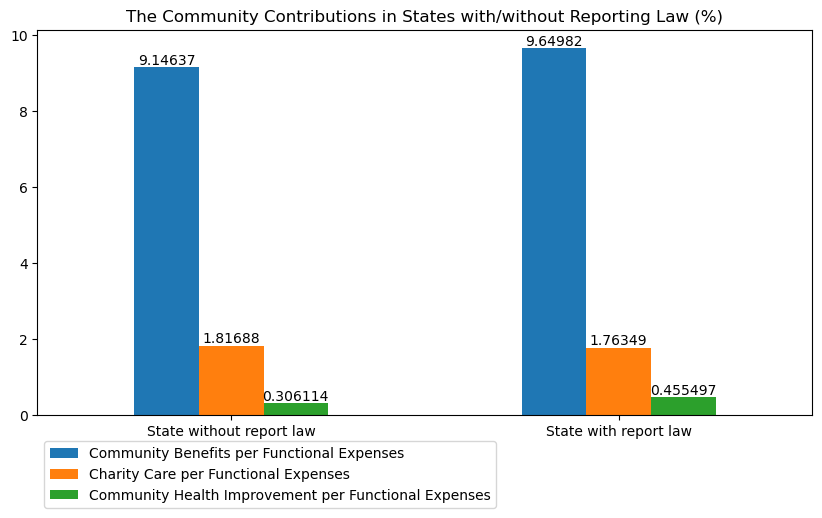

In [11]:
law_df = pd.DataFrame()
law_df[['tot_comm_bnfts_tot_func_exp_pct', 'chrty_care_tot_func_exp_pct',
        'comm_hlth_impr_svcs_comm_bnft_oper_tot_func_exp_pct']] = df[['state', 'tot_comm_bnfts_tot_func_exp_pct', 'chrty_care_tot_func_exp_pct',
                                                                           'comm_hlth_impr_svcs_comm_bnft_oper_tot_func_exp_pct']].groupby('state').mean()
law_df['state'] = law_df.index
law_df.reset_index(drop=True, inplace=True)

law_df = pd.merge(law_df, law_check, on='state')
law_df = law_df.groupby('st_law_req_hosp_rpt_comm_bnfts_f').mean()
law_df.index = ['State without report law', 'State with report law']
law_df.columns = ['Community Benefits per Functional Expenses', 'Charity Care per Functional Expenses', 'Community Health Improvement per Functional Expenses']

ax = law_df.plot(kind='bar', rot=0, title='The Community Contributions in States with/without Reporting Law (%)', figsize=(10,5))
ax.legend(loc='upper left', bbox_to_anchor=(0, -0.05))
for container in ax.containers:
    ax.bar_label(container)

**Answer:** As we can see, states with reporting law surpass states without report law in community benefit and health improvement in percentage. However, despite of not having reporting law, these states still use a high percentage of their functional expenses for charity care purposes and higher than the states with reporting law.